# Load libraries

In [1]:
library(ggplot2)
library(cowplot)
library(dplyr)
library(tidyr)
library(eulerr)
library(data.table)
library(scales)
library(data.table)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




# Load data
## Meta data

In [2]:
#load meta data
qc_data <- read.csv('/Users/rusi2317/projects/DBNascent_Analysis/data/metadata/20211026_db_output.csv',
                     fill = TRUE, sep=',', header=TRUE)
dim(qc_data)
head(qc_data)


[1] 2881   62

,identifier,srp,srr,srz,replicate,protocol,organism,sample.type,cell.type,clone_individual,⋯,rseqc_five_utr,rseqc_three_utr,rseqc_intron,intron_rpk,exint_ratio,distinct_tenmillion_prop,genome_prop_cov,avg_fold_cov,samp_qc_score,samp_data_score
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,Jiang2018multi,SRP133625,SRR6789175,SRR6789175,rep1,GRO-seq,H. sapiens,cell line,HCT116,,⋯,13169755,1570971,13913192,10.35,4.005797,0.53434150,0.1616894204,1.69124924,2,2
2,Jiang2018multi,SRP133625,SRR6789176,SRR6789176,rep2,GRO-seq,H. sapiens,cell line,HCT116,,⋯,8654825,2726810,25635316,19.07,3.274253,0.76100050,0.2179259333,1.54168071,1,2
3,Orioli2016human,SRP064802,SRR2634645,SRR2634645,rep1,other,H. sapiens,cell line,IMR90,,⋯,3412166,3555460,1989643,1.48,2.020270,0.05481745,0.0079829801,0.57825595,4,5
4,Orioli2016human,SRP064802,SRR2634646,SRR2634646,rep2,other,H. sapiens,cell line,IMR90,,⋯,3132307,3414405,1863128,1.39,2.223022,0.05493480,0.0078120794,0.54060952,4,5
5,Orioli2016human,SRP064802,SRR2634647,SRR2634647,rep3,other,H. sapiens,cell line,IMR90,,⋯,3369366,3321637,1621959,1.21,3.553719,0.05111945,0.0064884831,0.55461626,4,5
6,Orioli2016human,SRP064802,SRR2634648,SRR2634648,rep1,other,H. sapiens,cell line,IMR90,,⋯,46311,19035,28717,0.02,0.500000,0.00785423,0.0003658053,0.04486242,5,5


## Paper QC

In [3]:
# load the paper qc data
qc_paper <- read.table('/Users/rusi2317/projects/DBNascent_Analysis/data/metadata/20211026_paper_qc_scores.csv',
                       fill = TRUE, sep=',', header=FALSE)
head(qc_paper)

,V1,V2
,<fct>,<dbl>
1,Aeby2020decapping,1.0
2,Agarwal2021kdm1a,1.0
3,Aho2019displacement,1.0
4,Akulenko2018transcriptional,3.0
5,Alexander2019imprinted,2.0
6,Alhusini2017genomewide,4.5


## Base composition

In [4]:
# get base composition for Tfit calls by paper
# master mumerge folder: /Users/rusi2317/projects/master_mumerge
base_composition <- read.table('/Users/rusi2317/projects/DBNascent_Analysis/data/metadata/gc_composition_central_300bp.txt',
                              fill = TRUE, sep='\t', header=TRUE)
base_composition$id <- as.character(base_composition$id)
base_composition$identifier <- as.character(lapply(strsplit(base_composition$id, '_'), `[`, 1))
base_composition$genome <- as.character(lapply(strsplit(base_composition$id, '_'), `[`, 2))
base_composition$bidir <- as.character(lapply(strsplit(base_composition$id, '_'), `[`, 3))
head(base_composition)

,id,percent_gc,percent_at,sum,identifier,genome,bidir
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Aeby2020decapping_mm10_dreg_MUMERGE,0.5315360,0.4684640,1,Aeby2020decapping,mm10,dreg
2,Aeby2020decapping_mm10_tfit_MUMERGE,0.5167280,0.4832720,1,Aeby2020decapping,mm10,tfit
3,Agarwal2021kdm1a_mm10_dreg_MUMERGE,0.5351998,0.4648002,1,Agarwal2021kdm1a,mm10,dreg
4,Agarwal2021kdm1a_mm10_tfit_MUMERGE,0.5223468,0.4776532,1,Agarwal2021kdm1a,mm10,tfit
5,Aho2019displacement_hg38_dreg_MUMERGE,0.5540629,0.4459371,1,Aho2019displacement,hg38,dreg
6,Aho2019displacement_hg38_tfit_MUMERGE,0.5272901,0.4727099,1,Aho2019displacement,hg38,tfit


## TSS Overlaps

### TSSs

In [5]:
##get paths for the counts tables
tss_files <- list.files(path="/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap", 
                              pattern="tss.bed$",full.names=TRUE)
length(tss_files)
head(tss_files)

[1] 434

[1] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aeby2020decapping_mm10_dreg_MUMERGE-tss.bed"  
[2] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aeby2020decapping_mm10_tfit_MUMERGE-tss.bed"  
[3] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss.bed"   
[4] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss.bed"   
[5] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aho2019displacement_hg38_dreg_MUMERGE-tss.bed"
[6] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aho2019displacement_hg38_tfit_MUMERGE-tss.bed"

In [6]:
#Initialize a data.frame 
tss_bidir_matrix <- matrix(0, ncol = 2, nrow = length(tss_files))
tss_bidir_df <- data.frame(tss_bidir_matrix)

#merge the remaining files
for(i in 1:length(tss_files)){
    bidir <- read.table(tss_files[i], header=FALSE)
    tss_bidir_df[i,] <- c(as.character(lapply(strsplit(as.character(lapply(strsplit(tss_files[i], '/'), `[`, 8)), '\\.'), `[`,1)),
                       nrow(bidir))
    

}

In [7]:
tss_bidir_df$author <- as.character(lapply(strsplit(tss_bidir_df$X1, '_'), `[`, 1))
tss_bidir_df$genome <- as.character(lapply(strsplit(tss_bidir_df$X1, '_'), `[`, 2))
tss_bidir_df$bidir <- as.character(lapply(strsplit(tss_bidir_df$X1, '_'), `[`, 3))
tss_bidir_df$tss <- rep('TSS', nrow(tss_bidir_df))
tss_bidir_df$author_genome_bidir <- paste0(tss_bidir_df$author,":",
                                     tss_bidir_df$genome,":",
                                     tss_bidir_df$bidir)
head(tss_bidir_df)

,X1,X2,author,genome,bidir,tss,author_genome_bidir
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Aeby2020decapping_mm10_dreg_MUMERGE-tss,15813,Aeby2020decapping,mm10,dreg,TSS,Aeby2020decapping:mm10:dreg
2,Aeby2020decapping_mm10_tfit_MUMERGE-tss,21673,Aeby2020decapping,mm10,tfit,TSS,Aeby2020decapping:mm10:tfit
3,Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss,13658,Agarwal2021kdm1a,mm10,dreg,TSS,Agarwal2021kdm1a:mm10:dreg
4,Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss,16324,Agarwal2021kdm1a,mm10,tfit,TSS,Agarwal2021kdm1a:mm10:tfit
5,Aho2019displacement_hg38_dreg_MUMERGE-tss,13904,Aho2019displacement,hg38,dreg,TSS,Aho2019displacement:hg38:dreg
6,Aho2019displacement_hg38_tfit_MUMERGE-tss,17012,Aho2019displacement,hg38,tfit,TSS,Aho2019displacement:hg38:tfit


### non-TSSs

In [8]:
##get paths for the counts tables
non_tss_files <- list.files(path="/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap", 
                              pattern="non.bed$",full.names=TRUE)
length(non_tss_files)
head(non_tss_files)

[1] 434

[1] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aeby2020decapping_mm10_dreg_MUMERGE-tss_non.bed"  
[2] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aeby2020decapping_mm10_tfit_MUMERGE-tss_non.bed"  
[3] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss_non.bed"   
[4] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss_non.bed"   
[5] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aho2019displacement_hg38_dreg_MUMERGE-tss_non.bed"
[6] "/Users/rusi2317/projects/master_mumerge/processed_data/tss_overlap/Aho2019displacement_hg38_tfit_MUMERGE-tss_non.bed"

In [9]:
#Initialize a data.frame 
non_tss_bidir_matrix <- matrix(0, ncol = 2, nrow = length(non_tss_files))
non_tss_bidir_df <- data.frame(non_tss_bidir_matrix)

#merge the remaining files
for(i in 1:length(non_tss_files)){
    bidir <- read.table(non_tss_files[i], header=FALSE)
    non_tss_bidir_df[i,] <- c(as.character(lapply(strsplit(as.character(lapply(strsplit(non_tss_files[i], '/'), `[`, 8)), '\\.'), `[`,1)),
                       nrow(bidir))
    

}

In [10]:
non_tss_bidir_df$author <- as.character(lapply(strsplit(non_tss_bidir_df$X1, '_'), `[`, 1))
non_tss_bidir_df$genome <- as.character(lapply(strsplit(non_tss_bidir_df$X1, '_'), `[`, 2))
non_tss_bidir_df$bidir <- as.character(lapply(strsplit(non_tss_bidir_df$X1, '_'), `[`, 3))
non_tss_bidir_df$non_tss <- rep('No-TSS', nrow(non_tss_bidir_df))
non_tss_bidir_df$author_genome_bidir <- paste0(non_tss_bidir_df$author,":",
                                               non_tss_bidir_df$genome,":",
                                               non_tss_bidir_df$bidir)
head(non_tss_bidir_df)

,X1,X2,author,genome,bidir,non_tss,author_genome_bidir
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Aeby2020decapping_mm10_dreg_MUMERGE-tss_non,94845,Aeby2020decapping,mm10,dreg,No-TSS,Aeby2020decapping:mm10:dreg
2,Aeby2020decapping_mm10_tfit_MUMERGE-tss_non,161807,Aeby2020decapping,mm10,tfit,No-TSS,Aeby2020decapping:mm10:tfit
3,Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss_non,87770,Agarwal2021kdm1a,mm10,dreg,No-TSS,Agarwal2021kdm1a:mm10:dreg
4,Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss_non,94431,Agarwal2021kdm1a,mm10,tfit,No-TSS,Agarwal2021kdm1a:mm10:tfit
5,Aho2019displacement_hg38_dreg_MUMERGE-tss_non,27908,Aho2019displacement,hg38,dreg,No-TSS,Aho2019displacement:hg38:dreg
6,Aho2019displacement_hg38_tfit_MUMERGE-tss_non,44157,Aho2019displacement,hg38,tfit,No-TSS,Aho2019displacement:hg38:tfit


### Percent overlapping TSSs

In [11]:
tss_summary <- merge(tss_bidir_df, 
                     non_tss_bidir_df,
                     by='author_genome_bidir')

dim(tss_summary)
head(tss_summary)

[1] 434  13

,author_genome_bidir,X1.x,X2.x,author.x,genome.x,bidir.x,tss,X1.y,X2.y,author.y,genome.y,bidir.y,non_tss
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Aeby2020decapping:mm10:dreg,Aeby2020decapping_mm10_dreg_MUMERGE-tss,15813,Aeby2020decapping,mm10,dreg,TSS,Aeby2020decapping_mm10_dreg_MUMERGE-tss_non,94845,Aeby2020decapping,mm10,dreg,No-TSS
2,Aeby2020decapping:mm10:tfit,Aeby2020decapping_mm10_tfit_MUMERGE-tss,21673,Aeby2020decapping,mm10,tfit,TSS,Aeby2020decapping_mm10_tfit_MUMERGE-tss_non,161807,Aeby2020decapping,mm10,tfit,No-TSS
3,Agarwal2021kdm1a:mm10:dreg,Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss,13658,Agarwal2021kdm1a,mm10,dreg,TSS,Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss_non,87770,Agarwal2021kdm1a,mm10,dreg,No-TSS
4,Agarwal2021kdm1a:mm10:tfit,Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss,16324,Agarwal2021kdm1a,mm10,tfit,TSS,Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss_non,94431,Agarwal2021kdm1a,mm10,tfit,No-TSS
5,Aho2019displacement:hg38:dreg,Aho2019displacement_hg38_dreg_MUMERGE-tss,13904,Aho2019displacement,hg38,dreg,TSS,Aho2019displacement_hg38_dreg_MUMERGE-tss_non,27908,Aho2019displacement,hg38,dreg,No-TSS
6,Aho2019displacement:hg38:tfit,Aho2019displacement_hg38_tfit_MUMERGE-tss,17012,Aho2019displacement,hg38,tfit,TSS,Aho2019displacement_hg38_tfit_MUMERGE-tss_non,44157,Aho2019displacement,hg38,tfit,No-TSS


In [12]:
tss_summary$total_calls <- as.numeric(tss_summary$X2.x) + as.numeric(tss_summary$X2.y)
tss_summary$percent_tss <- as.numeric(tss_summary$X2.x)/tss_summary$total_calls
tss_summary$id <- paste0(tss_summary$author.x,'_', 
                         tss_summary$genome.x, '_',
                        tss_summary$bidir.x,'_',
                        'MUMERGE')
head(tss_summary)

,author_genome_bidir,X1.x,X2.x,author.x,genome.x,bidir.x,tss,X1.y,X2.y,author.y,genome.y,bidir.y,non_tss,total_calls,percent_tss,id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Aeby2020decapping:mm10:dreg,Aeby2020decapping_mm10_dreg_MUMERGE-tss,15813,Aeby2020decapping,mm10,dreg,TSS,Aeby2020decapping_mm10_dreg_MUMERGE-tss_non,94845,Aeby2020decapping,mm10,dreg,No-TSS,110658,0.1428997,Aeby2020decapping_mm10_dreg_MUMERGE
2,Aeby2020decapping:mm10:tfit,Aeby2020decapping_mm10_tfit_MUMERGE-tss,21673,Aeby2020decapping,mm10,tfit,TSS,Aeby2020decapping_mm10_tfit_MUMERGE-tss_non,161807,Aeby2020decapping,mm10,tfit,No-TSS,183480,0.1181219,Aeby2020decapping_mm10_tfit_MUMERGE
3,Agarwal2021kdm1a:mm10:dreg,Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss,13658,Agarwal2021kdm1a,mm10,dreg,TSS,Agarwal2021kdm1a_mm10_dreg_MUMERGE-tss_non,87770,Agarwal2021kdm1a,mm10,dreg,No-TSS,101428,0.1346571,Agarwal2021kdm1a_mm10_dreg_MUMERGE
4,Agarwal2021kdm1a:mm10:tfit,Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss,16324,Agarwal2021kdm1a,mm10,tfit,TSS,Agarwal2021kdm1a_mm10_tfit_MUMERGE-tss_non,94431,Agarwal2021kdm1a,mm10,tfit,No-TSS,110755,0.1473884,Agarwal2021kdm1a_mm10_tfit_MUMERGE
5,Aho2019displacement:hg38:dreg,Aho2019displacement_hg38_dreg_MUMERGE-tss,13904,Aho2019displacement,hg38,dreg,TSS,Aho2019displacement_hg38_dreg_MUMERGE-tss_non,27908,Aho2019displacement,hg38,dreg,No-TSS,41812,0.3325361,Aho2019displacement_hg38_dreg_MUMERGE
6,Aho2019displacement:hg38:tfit,Aho2019displacement_hg38_tfit_MUMERGE-tss,17012,Aho2019displacement,hg38,tfit,TSS,Aho2019displacement_hg38_tfit_MUMERGE-tss_non,44157,Aho2019displacement,hg38,tfit,No-TSS,61169,0.2781147,Aho2019displacement_hg38_tfit_MUMERGE


# Quality control summary

## Merge the base composition and tss data

In [13]:
base_composition_tss <- merge(base_composition[c('id','percent_gc','percent_at',
                                                'identifier','genome','bidir')],
                              tss_summary[c('id','percent_tss')])
head(base_composition_tss)

,id,percent_gc,percent_at,identifier,genome,bidir,percent_tss
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,Aeby2020decapping_mm10_dreg_MUMERGE,0.5315360,0.4684640,Aeby2020decapping,mm10,dreg,0.1428997
2,Aeby2020decapping_mm10_tfit_MUMERGE,0.5167280,0.4832720,Aeby2020decapping,mm10,tfit,0.1181219
3,Agarwal2021kdm1a_mm10_dreg_MUMERGE,0.5351998,0.4648002,Agarwal2021kdm1a,mm10,dreg,0.1346571
4,Agarwal2021kdm1a_mm10_tfit_MUMERGE,0.5223468,0.4776532,Agarwal2021kdm1a,mm10,tfit,0.1473884
5,Aho2019displacement_hg38_dreg_MUMERGE,0.5540629,0.4459371,Aho2019displacement,hg38,dreg,0.3325361
6,Aho2019displacement_hg38_tfit_MUMERGE,0.5272901,0.4727099,Aho2019displacement,hg38,tfit,0.2781147


In [14]:
base_composition_tss_tfit <- subset(base_composition_tss, bidir == 'tfit')
base_composition_tss_dreg <- subset(base_composition_tss, bidir == 'dreg')

## Comparing Tfit and dREG base content

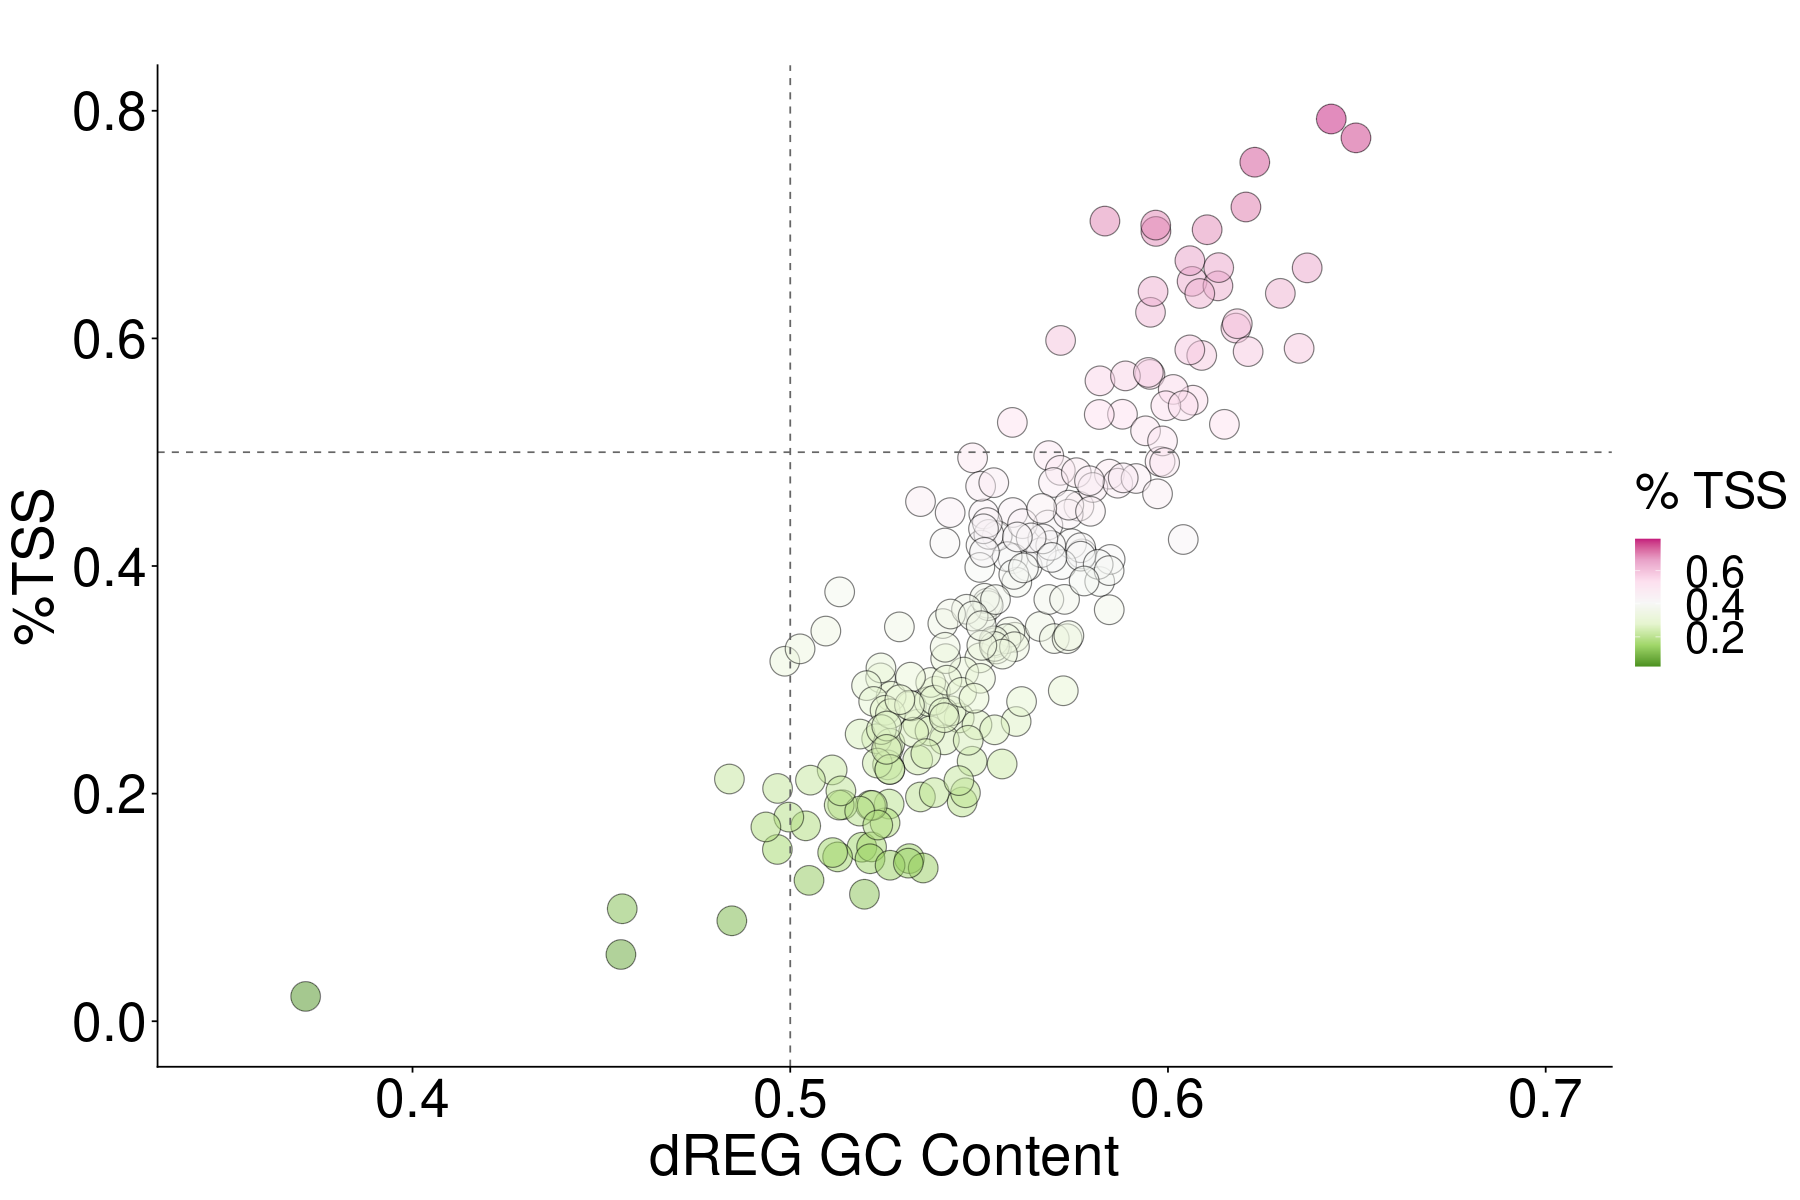

In [46]:
options(repr.plot.width=15, repr.plot.height=10)

tss_dreg <- ggplot(subset(base_composition_tss, bidir=='dreg'), 
           aes(y=as.numeric(percent_tss),
               x=as.numeric(percent_gc),
              fill=as.numeric(percent_tss))) + 
      geom_point(size=8,shape=21, alpha=0.5)+
    theme_cowplot() + 
    xlim(0.35,0.7) +
    ylim(0,0.8) +
    scale_fill_distiller(name = '% TSS', palette = "PiYG") +
    #scale_fill_brewer(name = 'Paper QC', palette = "Spectral", direction=-1) +
    labs(title = " ", #Base Composition
         y = "%TSS", 
         x = "dREG GC Content") + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "gray40") +
    geom_vline(xintercept=0.5, linetype="dashed", color = "gray40") +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "bold",
                                   size = 26),
          axis.title = element_text(size = 34), 
          axis.text = element_text(size = 32),
         legend.title = element_text(size = 30),
         legend.text = element_text(size = 26))

tss_dreg

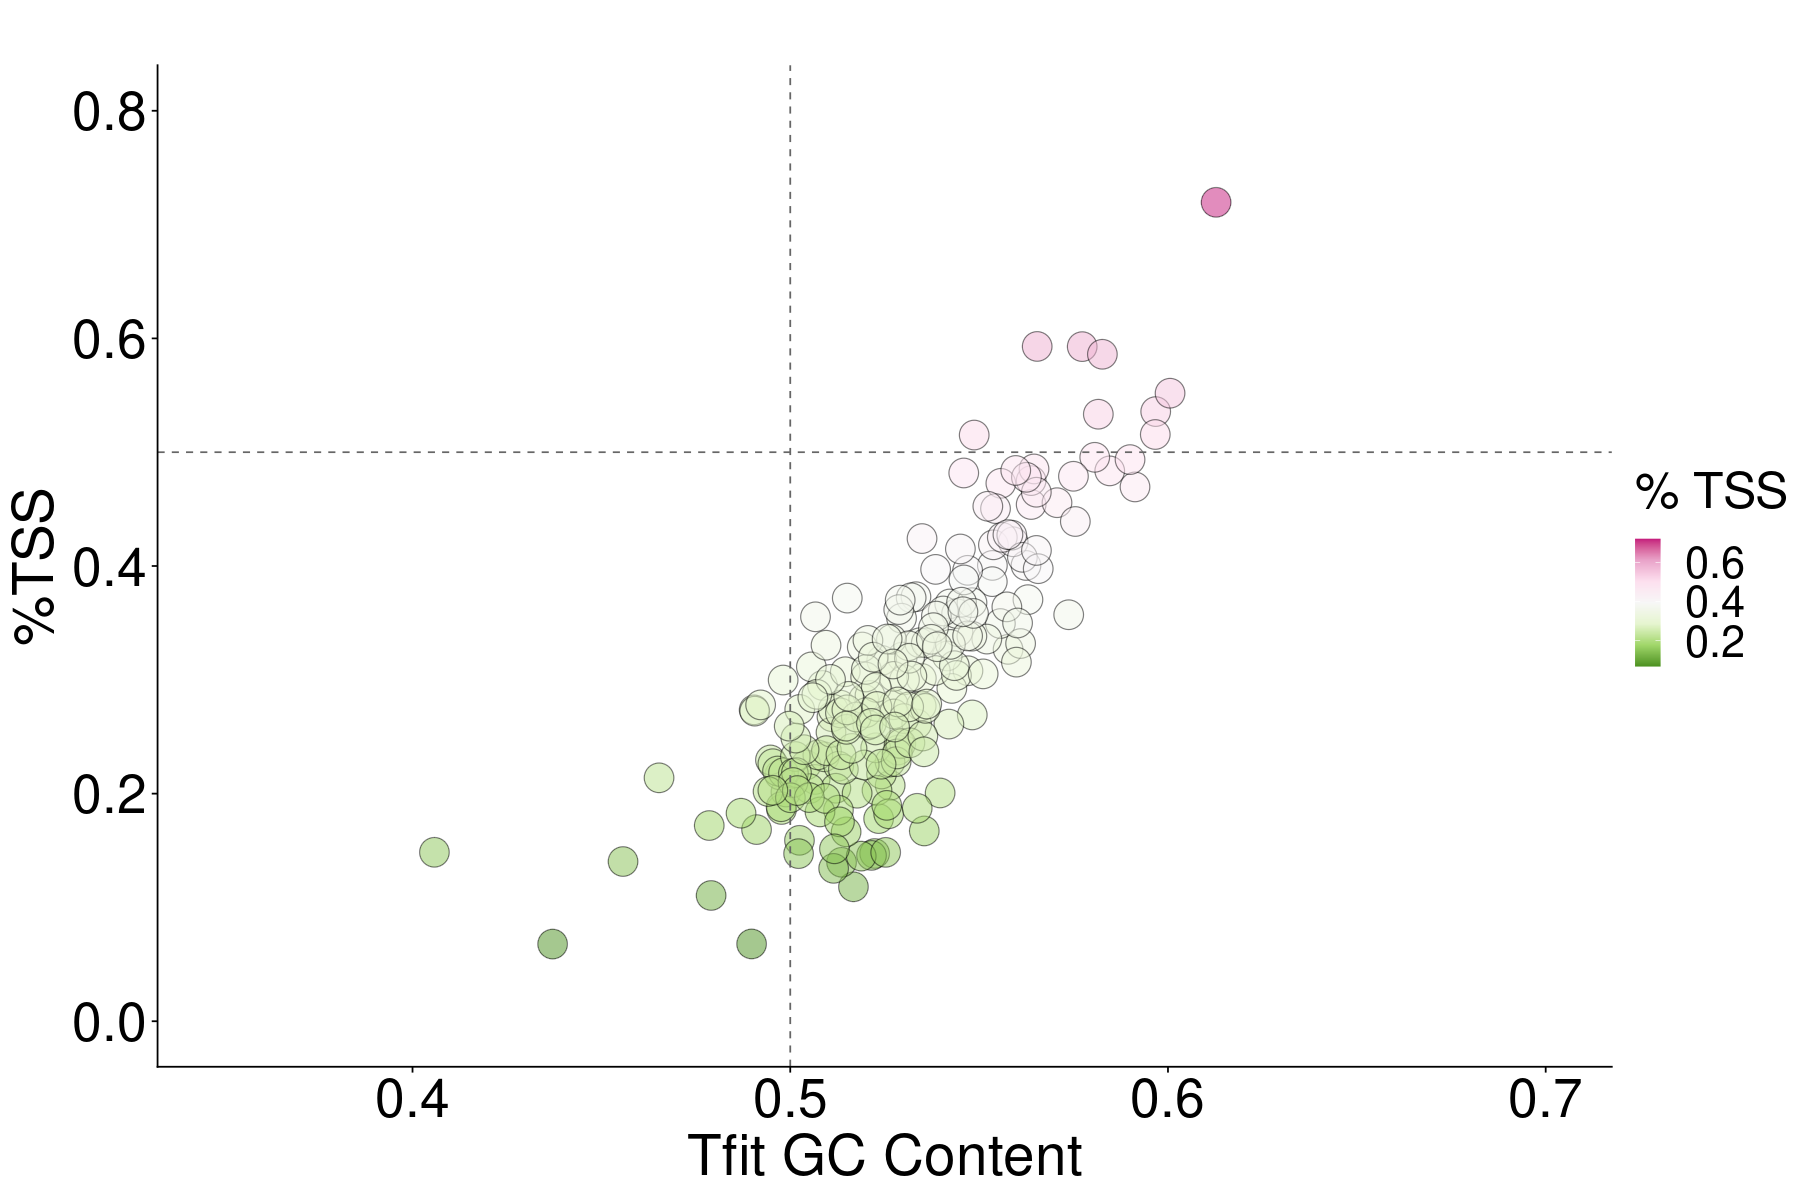

In [47]:
options(repr.plot.width=15, repr.plot.height=10)

tss_tfit <- ggplot(subset(base_composition_tss, bidir=='tfit'), 
           aes(y=as.numeric(percent_tss),
               x=as.numeric(percent_gc),
              fill=as.numeric(percent_tss))) + 
      geom_point(size=8,shape=21, alpha=0.5)+
    theme_cowplot() + 
    xlim(0.35,0.7) +
    ylim(0,0.8) +
    scale_fill_distiller(name = '% TSS', palette = "PiYG") +
    #scale_fill_brewer(name = 'Paper QC', palette = "Spectral", direction=-1) +
    labs(title = " ", #Base Composition
         y = "%TSS", 
         x = "Tfit GC Content") + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "gray40") +
    geom_vline(xintercept=0.5, linetype="dashed", color = "gray40") +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "bold",
                                   size = 26),
          axis.title = element_text(size = 34), 
          axis.text = element_text(size = 32),
         legend.title = element_text(size = 30),
         legend.text = element_text(size = 26))
tss_tfit

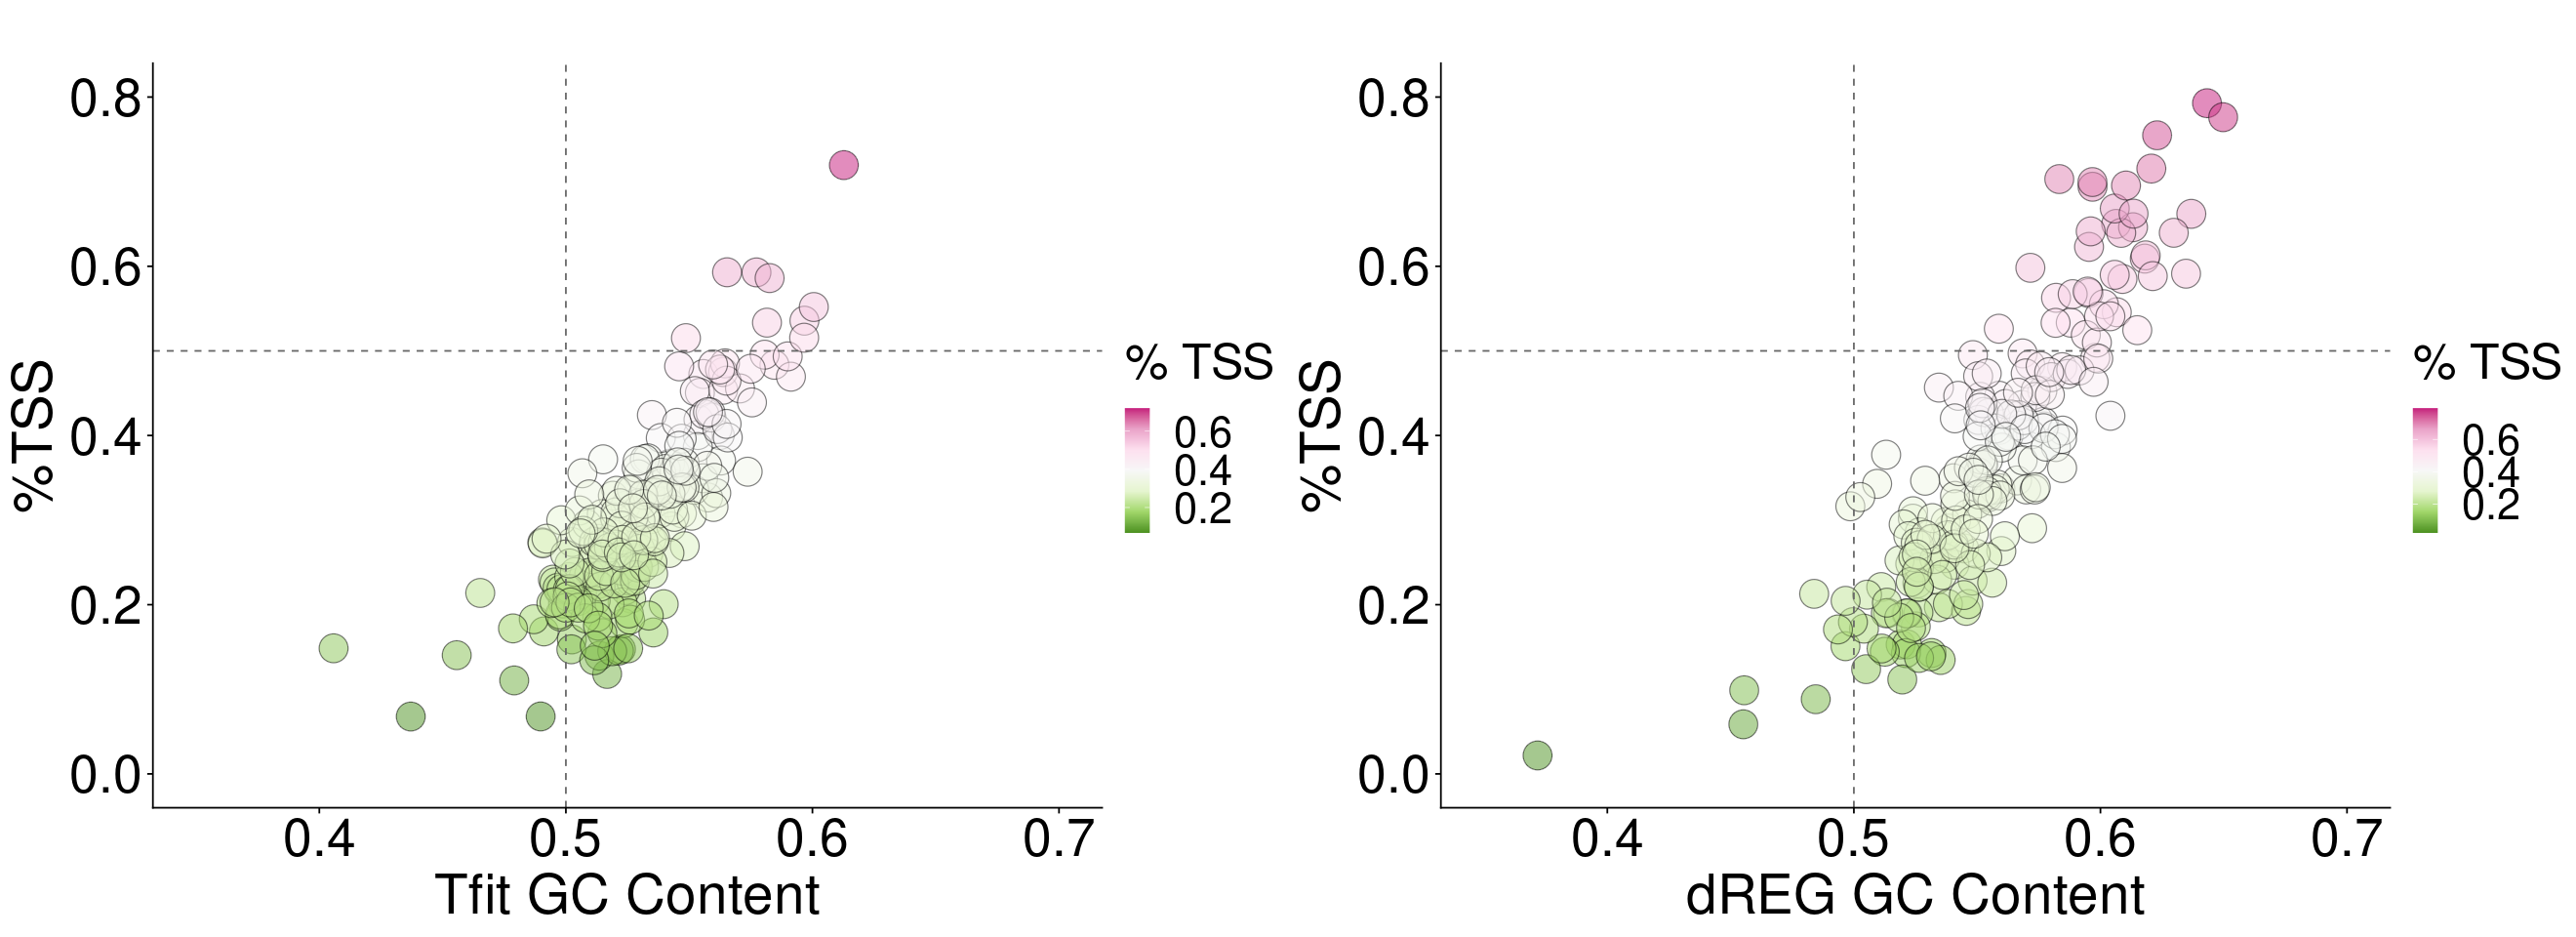

In [48]:
options(repr.plot.width=22, repr.plot.height=8)
cowplot::plot_grid(tss_tfit,tss_dreg,
          label_size = 24,
         ncol = 2)

In [49]:
ggsave(tss_dreg, width = 15, height = 10,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/tss_gc_content_dreg.pdf", 
       bg = "transparent")

ggsave(tss_tfit, width = 15, height = 10,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/tss_gc_content_tfit.pdf", 
       bg = "transparent")

## Exploring filtering papers

In [22]:
base_composition_tss2 <- merge(base_composition_tss_tfit, 
                               base_composition_tss_dreg,
                              by='identifier')
head(base_composition_tss2)

,identifier,id.x,percent_gc.x,percent_at.x,genome.x,bidir.x,percent_tss.x,id.y,percent_gc.y,percent_at.y,genome.y,bidir.y,percent_tss.y
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,Aeby2020decapping,Aeby2020decapping_mm10_tfit_MUMERGE,0.5167280,0.4832720,mm10,tfit,0.1181219,Aeby2020decapping_mm10_dreg_MUMERGE,0.5315360,0.4684640,mm10,dreg,0.1428997
2,Agarwal2021kdm1a,Agarwal2021kdm1a_mm10_tfit_MUMERGE,0.5223468,0.4776532,mm10,tfit,0.1473884,Agarwal2021kdm1a_mm10_dreg_MUMERGE,0.5351998,0.4648002,mm10,dreg,0.1346571
3,Aho2019displacement,Aho2019displacement_hg38_tfit_MUMERGE,0.5272901,0.4727099,hg38,tfit,0.2781147,Aho2019displacement_hg38_dreg_MUMERGE,0.5540629,0.4459371,hg38,dreg,0.3325361
4,Alexander2019imprinted,Alexander2019imprinted_mm10_tfit_MUMERGE,0.5264595,0.4735405,mm10,tfit,0.2072415,Alexander2019imprinted_mm10_dreg_MUMERGE,0.5344662,0.4655338,mm10,dreg,0.1970685
5,Allen2014global,Allen2014global_hg38_tfit_MUMERGE,0.5285264,0.4714736,hg38,tfit,0.2382894,Allen2014global_hg38_dreg_MUMERGE,0.5189713,0.4810287,hg38,dreg,0.1529151
6,Anderson2020defining,Anderson2020defining_mm10_tfit_MUMERGE,0.5334800,0.4665200,mm10,tfit,0.2611965,Anderson2020defining_mm10_dreg_MUMERGE,0.5772235,0.4227765,mm10,dreg,0.4106421


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



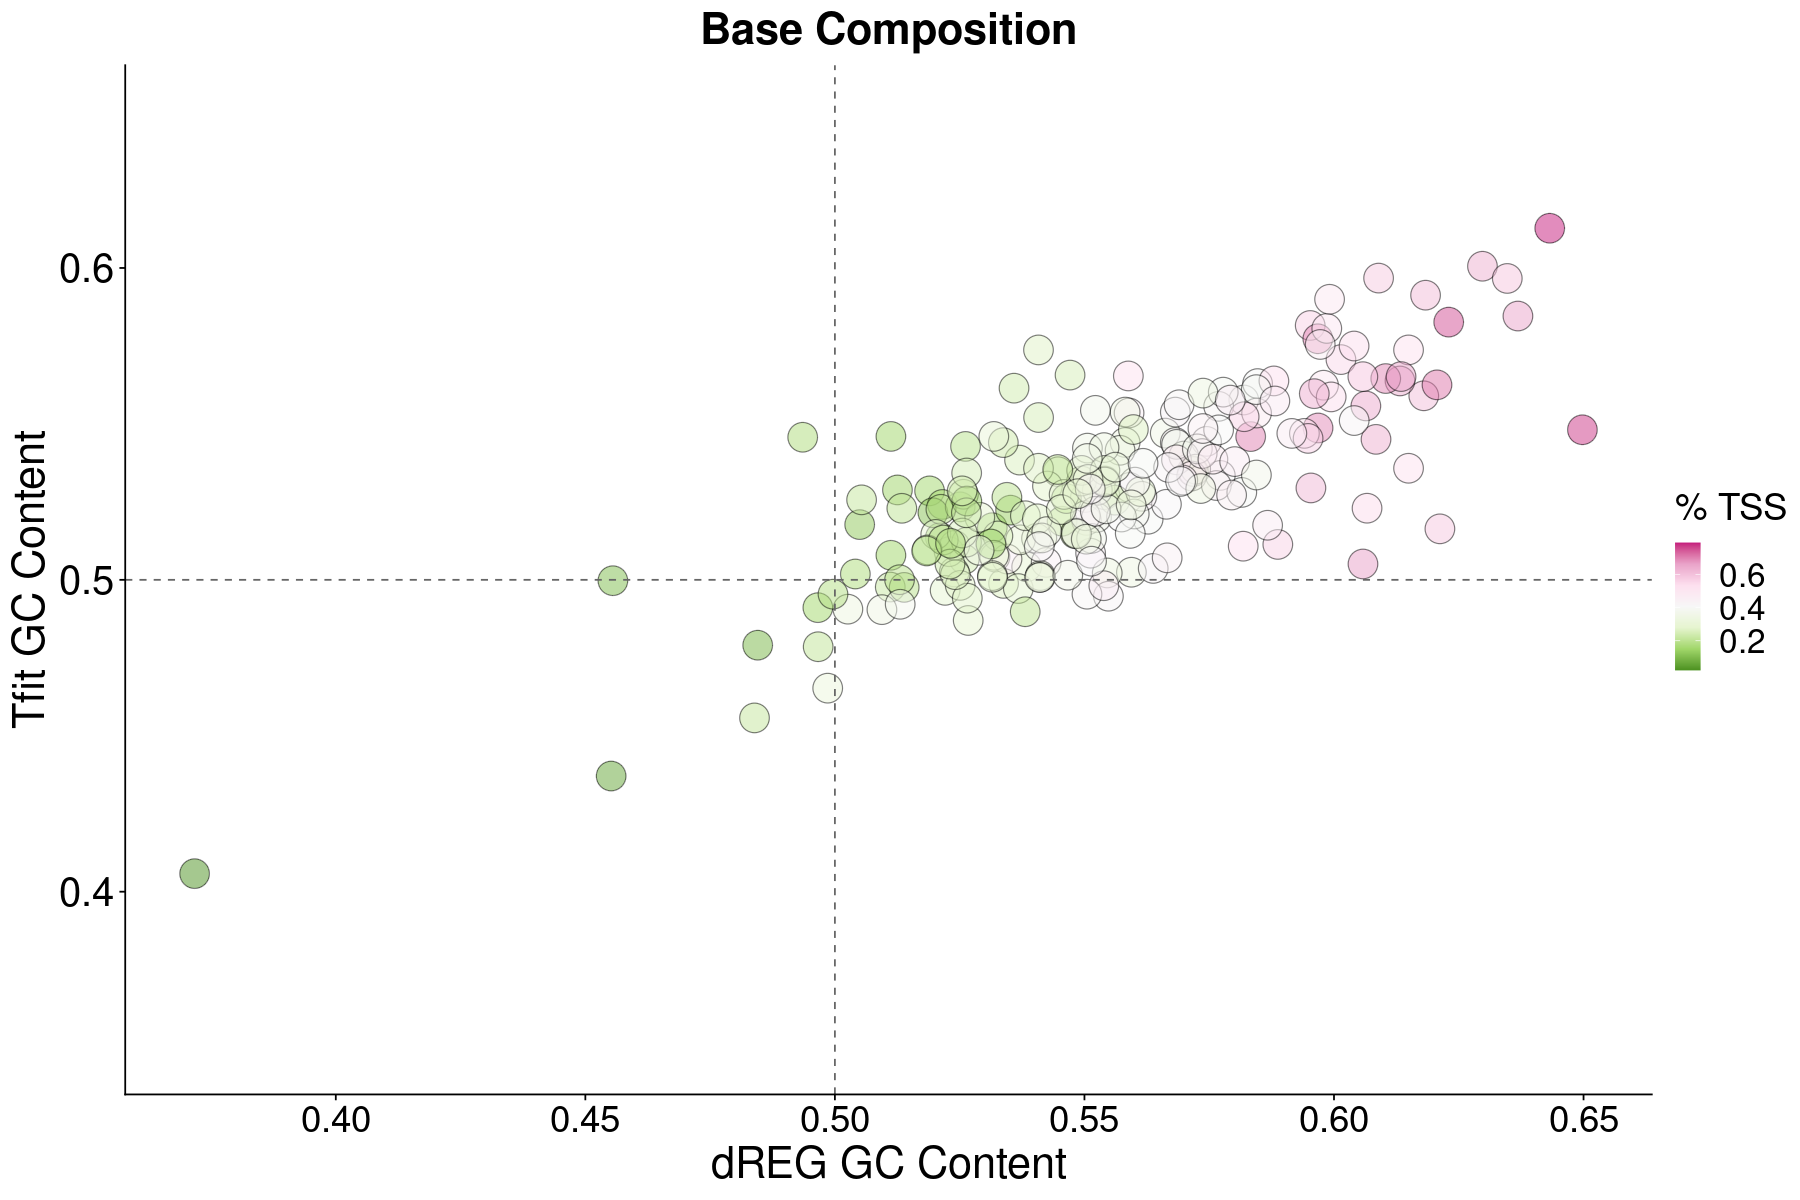

In [23]:
options(repr.plot.width=15, repr.plot.height=10)

tss1 <- ggplot(base_composition_tss2, 
           aes(x=as.numeric(percent_gc.y),
               y=as.numeric(percent_gc.x),
              fill=as.numeric(percent_tss.y))) + 
      geom_point(size=8,shape=21, alpha=0.5)+
    theme_cowplot() + 
    ylim(0.35,0.65) +
    ylim(0.35,0.65) +
    scale_fill_distiller(name = '% TSS', palette = "PiYG") +
    #scale_fill_brewer(name = 'Paper QC', palette = "Spectral", direction=-1) +
    labs(title = "Base Composition",
         x = "dREG GC Content", 
         y = "Tfit GC Content") + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "gray40") +
    geom_vline(xintercept=0.5, linetype="dashed", color = "gray40") +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "bold",
                                   size = 26),
          axis.title = element_text(size = 26), 
          axis.text = element_text(size = 24),
          axis.text.x = element_text(size = 22),
         legend.title = element_text(size = 22),
         legend.text = element_text(size = 20))
tss1

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



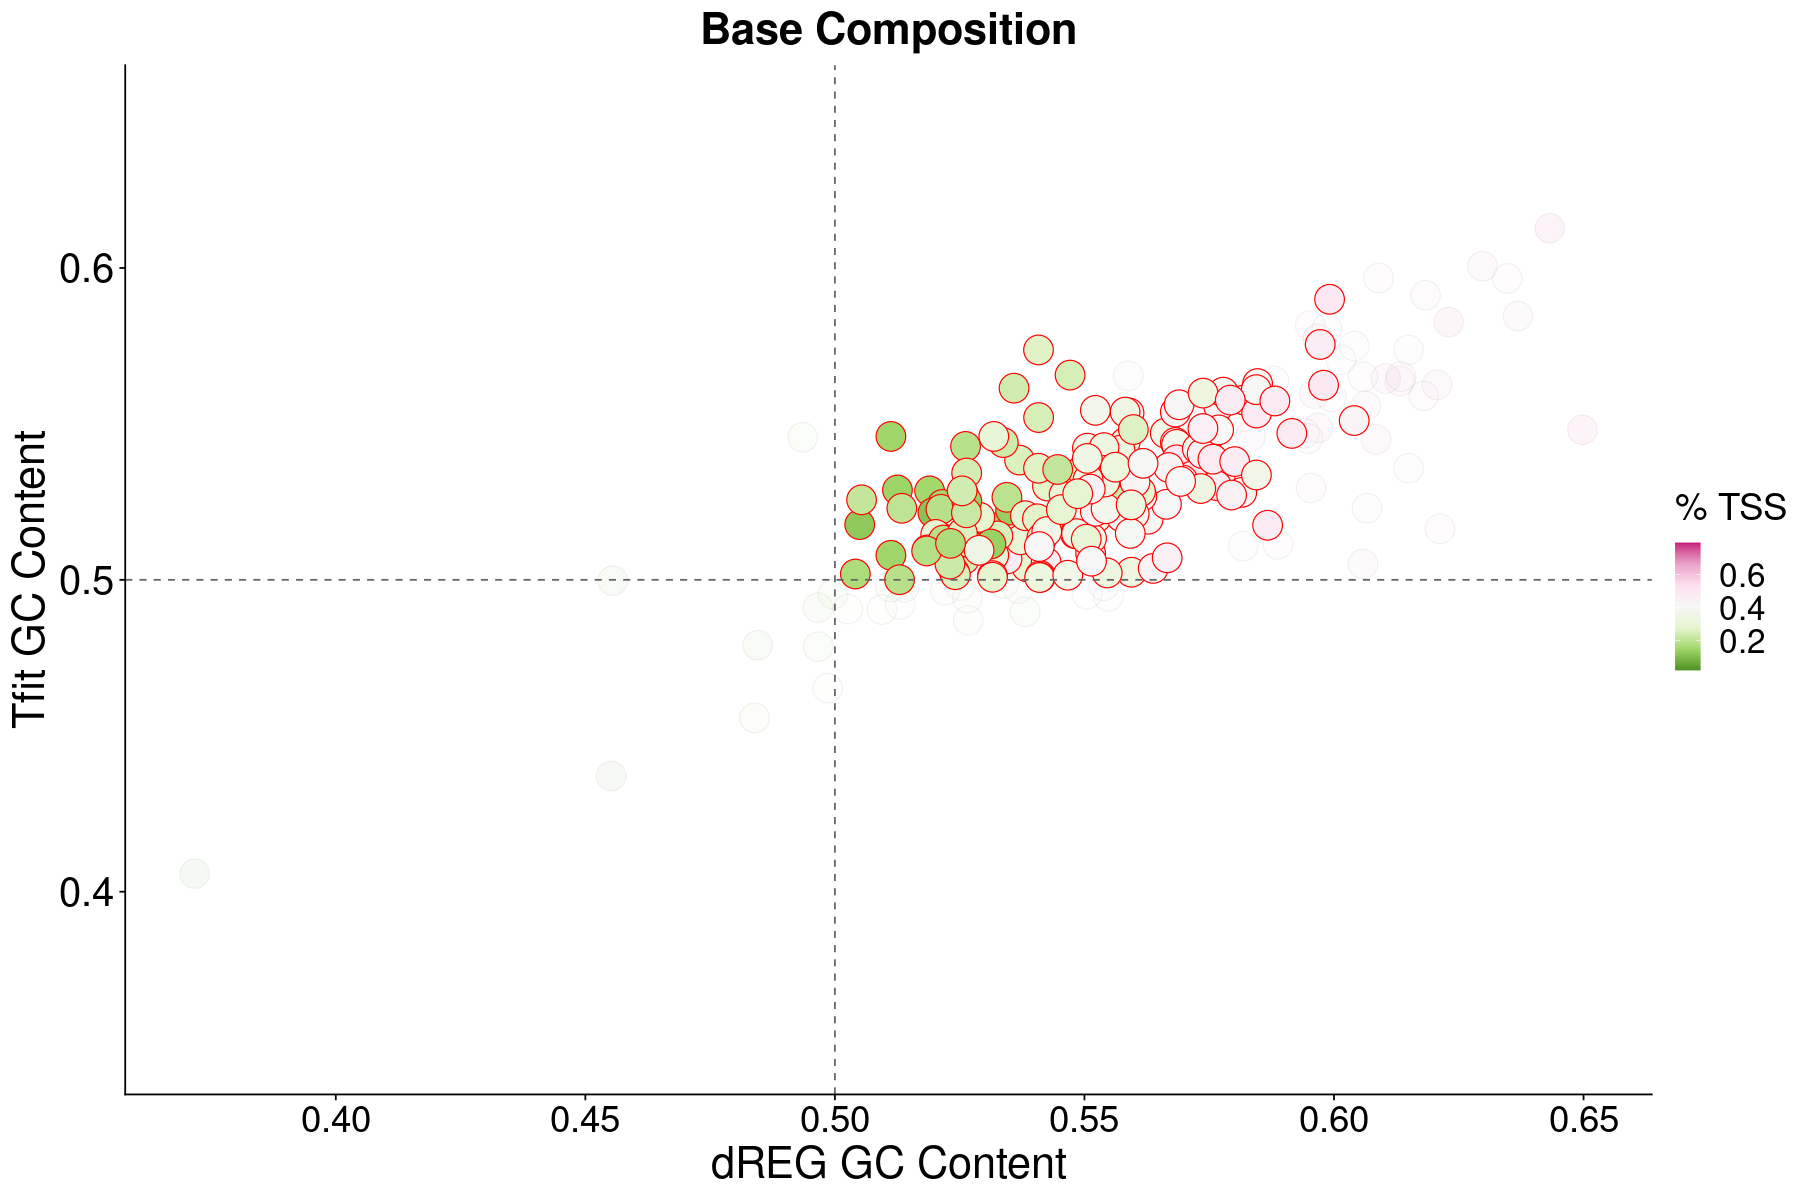

In [24]:
options(repr.plot.width=15, repr.plot.height=10)

tss2 <- ggplot(base_composition_tss2, 
           aes(x=as.numeric(percent_gc.y),
               y=as.numeric(percent_gc.x),
              fill=as.numeric(percent_tss.y))) + 
      geom_point(size=8,shape=21, alpha=0.05)+
    theme_cowplot() + 
    ylim(0.35,0.65) +
    ylim(0.35,0.65) +
    geom_point(data=subset(base_composition_tss2,
                           as.numeric(percent_tss.y) < 0.5 & 
                           as.numeric(percent_gc.x) > 0.5 &
                           as.numeric(percent_gc.y) > 0.5),
              aes(x=as.numeric(percent_gc.y),
               y=as.numeric(percent_gc.x)), 
               color='red', shape=21, size=8, alpha=1) +
    scale_fill_distiller(name = '% TSS', palette = "PiYG") +
    #scale_fill_brewer(name = 'Paper QC', palette = "Spectral", direction=-1) +
    labs(title = "Base Composition",
         x = "dREG GC Content", 
         y = "Tfit GC Content") + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "gray40") +
    geom_vline(xintercept=0.5, linetype="dashed", color = "gray40") +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "bold",
                                   size = 26),
          axis.title = element_text(size = 26), 
          axis.text = element_text(size = 24),
          axis.text.x = element_text(size = 22),
         legend.title = element_text(size = 22),
         legend.text = element_text(size = 20))
tss2

In [25]:
base_composition_tss_qc <- merge(base_composition_tss2, qc_paper,
                                by.x='identifier',by.y='V1')
dim(base_composition_tss_qc)
head(base_composition_tss_qc)

[1] 227  14

,identifier,id.x,percent_gc.x,percent_at.x,genome.x,bidir.x,percent_tss.x,id.y,percent_gc.y,percent_at.y,genome.y,bidir.y,percent_tss.y,V2
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Aeby2020decapping,Aeby2020decapping_mm10_tfit_MUMERGE,0.5167280,0.4832720,mm10,tfit,0.1181219,Aeby2020decapping_mm10_dreg_MUMERGE,0.5315360,0.4684640,mm10,dreg,0.1428997,1
2,Agarwal2021kdm1a,Agarwal2021kdm1a_mm10_tfit_MUMERGE,0.5223468,0.4776532,mm10,tfit,0.1473884,Agarwal2021kdm1a_mm10_dreg_MUMERGE,0.5351998,0.4648002,mm10,dreg,0.1346571,1
3,Aho2019displacement,Aho2019displacement_hg38_tfit_MUMERGE,0.5272901,0.4727099,hg38,tfit,0.2781147,Aho2019displacement_hg38_dreg_MUMERGE,0.5540629,0.4459371,hg38,dreg,0.3325361,1
4,Alexander2019imprinted,Alexander2019imprinted_mm10_tfit_MUMERGE,0.5264595,0.4735405,mm10,tfit,0.2072415,Alexander2019imprinted_mm10_dreg_MUMERGE,0.5344662,0.4655338,mm10,dreg,0.1970685,2
5,Allen2014global,Allen2014global_hg38_tfit_MUMERGE,0.5285264,0.4714736,hg38,tfit,0.2382894,Allen2014global_hg38_dreg_MUMERGE,0.5189713,0.4810287,hg38,dreg,0.1529151,3
6,Anderson2020defining,Anderson2020defining_mm10_tfit_MUMERGE,0.5334800,0.4665200,mm10,tfit,0.2611965,Anderson2020defining_mm10_dreg_MUMERGE,0.5772235,0.4227765,mm10,dreg,0.4106421,3


In [26]:
# filter by GC content and paper QC
filtered_qc_gc <- subset(base_composition_tss_qc,
                         as.numeric(percent_gc.x) > 0.5 &
                         as.numeric(percent_gc.y) > 0.5 &
                         as.numeric(V2) < 4)

# filyter by percent TSS
filtered_qc_gc_tss <- subset(filtered_qc_gc, 
                             as.numeric(percent_tss.y) < 0.5 |
                             as.numeric(percent_tss.x) < 0.5)

head(filtered_qc_gc_tss)

,identifier,id.x,percent_gc.x,percent_at.x,genome.x,bidir.x,percent_tss.x,id.y,percent_gc.y,percent_at.y,genome.y,bidir.y,percent_tss.y,V2
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Aeby2020decapping,Aeby2020decapping_mm10_tfit_MUMERGE,0.5167280,0.4832720,mm10,tfit,0.1181219,Aeby2020decapping_mm10_dreg_MUMERGE,0.5315360,0.4684640,mm10,dreg,0.1428997,1
2,Agarwal2021kdm1a,Agarwal2021kdm1a_mm10_tfit_MUMERGE,0.5223468,0.4776532,mm10,tfit,0.1473884,Agarwal2021kdm1a_mm10_dreg_MUMERGE,0.5351998,0.4648002,mm10,dreg,0.1346571,1
3,Aho2019displacement,Aho2019displacement_hg38_tfit_MUMERGE,0.5272901,0.4727099,hg38,tfit,0.2781147,Aho2019displacement_hg38_dreg_MUMERGE,0.5540629,0.4459371,hg38,dreg,0.3325361,1
4,Alexander2019imprinted,Alexander2019imprinted_mm10_tfit_MUMERGE,0.5264595,0.4735405,mm10,tfit,0.2072415,Alexander2019imprinted_mm10_dreg_MUMERGE,0.5344662,0.4655338,mm10,dreg,0.1970685,2
5,Allen2014global,Allen2014global_hg38_tfit_MUMERGE,0.5285264,0.4714736,hg38,tfit,0.2382894,Allen2014global_hg38_dreg_MUMERGE,0.5189713,0.4810287,hg38,dreg,0.1529151,3
6,Anderson2020defining,Anderson2020defining_mm10_tfit_MUMERGE,0.5334800,0.4665200,mm10,tfit,0.2611965,Anderson2020defining_mm10_dreg_MUMERGE,0.5772235,0.4227765,mm10,dreg,0.4106421,3


In [27]:
length(unique(filtered_qc_gc_tss$identifier))

[1] 159

In [55]:
paste('# Mouse papers used : ', 
      as.character(length(unique(subset(filtered_qc_gc_tss, genome.y == 'mm10')$identifier))))
paste('# Human papers used : ', 
      as.character(length(unique(subset(filtered_qc_gc_tss, genome.y == 'hg38')$identifier))))

[1] "# Mouse papers used :  61"

[1] "# Human papers used :  101"

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



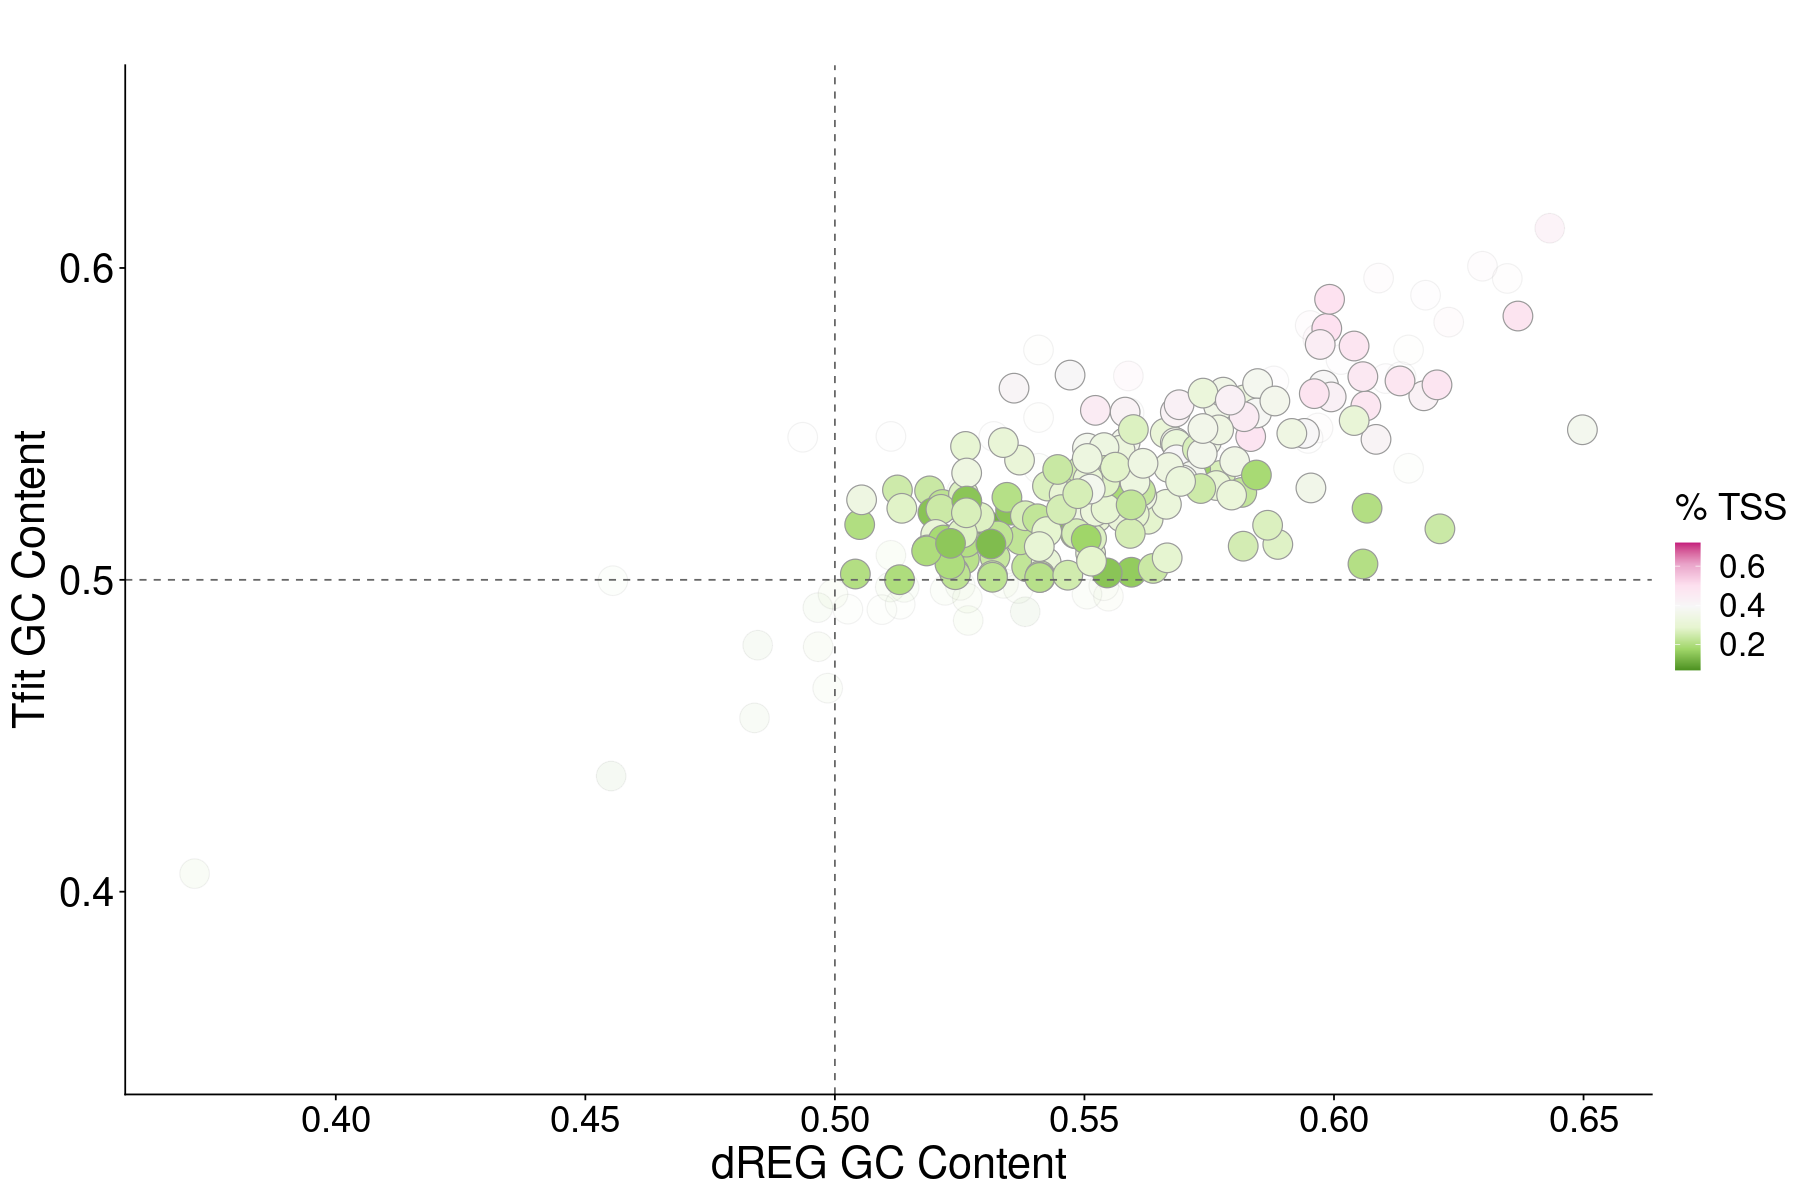

In [35]:
options(repr.plot.width=15, repr.plot.height=10)

tss3 <- ggplot(base_composition_tss_qc, 
           aes(x=as.numeric(percent_gc.y),
               y=as.numeric(percent_gc.x),
              fill=as.numeric(percent_tss.x))) + 
      geom_point(size=8,shape=21, alpha=0.05)+
    theme_cowplot() + 
    ylim(0.35,0.65) +
    ylim(0.35,0.65) +
    geom_point(data=filtered_qc_gc_tss, #test2,
              aes(x=as.numeric(percent_gc.y),
               y=as.numeric(percent_gc.x)), 
               color='gray60', shape=21, size=8, alpha=1) +
    scale_fill_distiller(name = '% TSS', palette = "PiYG") +
    #scale_fill_brewer(name = 'Paper QC', palette = "Spectral", direction=-1) +
    labs(title = " ", #Base Composition
         x = "dREG GC Content", 
         y = "Tfit GC Content") + 
    geom_hline(yintercept=0.5, linetype="dashed", color = "gray40") +
    geom_vline(xintercept=0.5, linetype="dashed", color = "gray40") +
    theme(plot.title = element_text(hjust = 0.5, 
                                    face = "bold",
                                   size = 26),
          axis.title = element_text(size = 26), 
          axis.text = element_text(size = 24),
          axis.text.x = element_text(size = 22),
         legend.title = element_text(size = 22),
         legend.text = element_text(size = 20))
tss3

In [36]:
ggsave(tss3, width = 15, height = 10,
       filename = "/Users/rusi2317/projects/DBNascent_Analysis/figures/tss_gc_filtered_dreg_tfit.pdf", 
       bg = "transparent")

# Saving QC filtered samples

In [31]:
qc_data_filtered <- qc_data[qc_data$identifier %in% 
                      unique(filtered_qc_gc_tss$identifier),]
dim(qc_data_filtered)

[1] 1441   62

In [32]:
qc_data_filtered

,identifier,srp,srr,srz,replicate,protocol,organism,sample.type,cell.type,clone_individual,⋯,rseqc_five_utr,rseqc_three_utr,rseqc_intron,intron_rpk,exint_ratio,distinct_tenmillion_prop,genome_prop_cov,avg_fold_cov,samp_qc_score,samp_data_score
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
15,Kantidakis2016mutation,SRP063847,SRR2432159,SRR2432159,rep1,GRO-seq,M. musculus,cell line,MEF,,⋯,1521488,5201194,18497438,16.77,12.618366,0.6912529,0.14312477,0.8827173,1,5
16,Kantidakis2016mutation,SRP063847,SRR2432160,SRR2432160,rep1,GRO-seq,M. musculus,cell line,MEF,,⋯,1318886,5432600,18796768,17.05,11.293842,0.6989129,0.15259603,0.8647243,1,5
17,Kantidakis2016mutation,SRP063847,SRR2432161,SRR2432161,rep2,GRO-seq,M. musculus,cell line,MEF,,⋯,1322374,4213952,14183448,12.86,12.437014,0.6492187,0.11779397,0.6997000,1,5
18,Kantidakis2016mutation,SRP063847,SRR2432162,SRR2432162,rep2,GRO-seq,M. musculus,cell line,MEF,,⋯,1881128,7763718,34252163,31.06,8.510303,0.8070985,0.19360659,1.3447241,1,4
29,Teppo2016genome,SRP056802,SRR1950492,SRZ1950491,rep1,GRO-seq,H. sapiens,cell line,Nalm6,,⋯,10874915,1371325,12504696,9.30,3.935484,0.5281649,0.13130418,1.4247784,2,2
30,Teppo2016genome,SRP056802,SRR1950494,SRZ1950493,rep2,GRO-seq,H. sapiens,cell line,Nalm6,,⋯,11304427,1498093,12230186,9.10,3.769231,0.4938774,0.11753761,1.4610195,2,3
31,Teppo2016genome,SRP056802,SRR1950496,SRZ1950495,rep1,GRO-seq,H. sapiens,cell line,Nalm6,,⋯,7733385,1134966,9207487,6.85,3.678832,0.5022536,0.10543999,1.0129358,2,3
32,Teppo2016genome,SRP056802,SRR1950497,SRZ1950497,rep2,GRO-seq,H. sapiens,cell line,Nalm6,,⋯,13857862,1129658,9343836,6.95,3.815827,0.3671787,0.10146421,1.6445870,3,3
33,Teppo2016genome,SRP056802,SRR1950500,SRZ1950499,rep1,GRO-seq,H. sapiens,cell line,Nalm6,,⋯,12128123,1376134,12379819,9.21,3.491857,0.4863174,0.13090182,1.5528507,2,2


In [33]:
qc_data_mm10 <- subset(qc_data_filtered, organism == 'M. musculus')
qc_data_hg38 <- subset(qc_data_filtered, organism == 'H. sapiens')

In [34]:
dim(qc_data_hg38)
dim(qc_data_mm10)

[1] 908  62

[1] 519  62

In [43]:
##mouse samples
write.table(qc_data_mm10[c('identifier', 'srz')], 
            '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/qc_filtered_samples/qc_filtered_mm10.csv',
            row.names = FALSE, col.names = TRUE, quote = FALSE, sep=',')

##tfit samples
write.table(qc_data_hg38[c('identifier', 'srz')], 
            '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/qc_filtered_samples/qc_filtered_hg38.csv',
            row.names = FALSE, col.names = TRUE, quote = FALSE, sep=',')

# Session Information

In [44]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scales_1.1.1      data.table_1.14.0 eulerr_6.1.0      tidyr_1.1.2      
[5] dplyr_1.0.2       cowplot_1.1.1     ggplot2_3.3.6    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.8.3       pillar_1.4.7       compiler_3.6.0     RColorBrewer_1.1-2
 [5] base64enc_0.1-3    tools_3.6.0        digest_0.6.27      uuid_0.1-4    